In [1]:
import pandas as pd

In [2]:
train_data = pd.read_csv('../../data/train.csv')
test_data = pd.read_csv('../../data/test.csv')
print('Shape train data:', train_data.shape)
print('Shape test data:', test_data.shape)

Shape train data: (891, 12)
Shape test data: (418, 11)


In [3]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Passengers with wrong number of siblings and parch
train_data.loc[train_data['PassengerId'] == 69, ['SibSp', 'Parch']] = [0,0]
train_data.loc[train_data['PassengerId'] == 1106, ['SibSp', 'Parch']] = [0,0]

#Age outlier
train_data.loc[train_data['PassengerId'] == 613, 'Age'] = 48

In [5]:
# Missing values
train_NA = train_data.isna().sum()
test_NA = test_data.isna().sum()
pd.concat([train_NA, test_NA],axis = 1 ,sort = False ,keys = ['Train NA', 'Test NA'],)

,Train NA,Test NA
PassengerId,0,0.0
Survived,0,NaN
Pclass,0,0.0
Name,0,0.0
Sex,0,0.0
Age,176,86.0
SibSp,0,0.0
Parch,0,0.0
Ticket,0,0.0
Fare,0,1.0


In [6]:
# Add new variable Age_NA indicates that there is no age in the original data.
train_data.loc[train_data['Age'].isna(), 'Age_NA'] = 1
train_data.loc[train_data['Age_NA'].isna(), 'Age_NA'] = 0

test_data.loc[test_data['Age'].isna(), 'Age_NA'] = 1       
test_data.loc[test_data['Age_NA'].isna(), 'Age_NA'] = 0

# titles categories dict
title_dict = {  'Mr':     'Mr',
                'Mrs':    'Mrs',
                'Miss':   'Miss',
                'Master': 'Master',              
                'Ms':     'Miss',
                'Mme':    'Mrs',
                'Mlle':   'Miss',
                'Capt':   'military',
                'Col':    'military',
                'Major':  'military',
                'Dr':     'Dr',
                'Rev':    'Rev',                  
                'Sir':    'honor',
                'the Countess': 'honor',
                'Lady':   'honor',
                'Jonkheer': 'honor',
                'Don':    'honor',
                'Dona':   'honor' }

# add title variable
train_data['Title'] = train_data['Name'].str.split(',', expand = True)[1].str.split('.', expand = True)[0].str.strip(' ')
test_data['Title'] = test_data['Name'].str.split(',', expand = True)[1].str.split('.', expand = True)[0].str.strip(' ')

# map titles to category
train_data['Title_category'] = train_data['Title'].map(title_dict)
test_data['Title_category'] = test_data['Title'].map(title_dict)

# delete Title variable
del train_data['Title']
del test_data['Title']

# Filling the missing values in Age with the medians of Sex and Pclass, Title groups
train_data['Age'] = train_data.groupby(['Pclass', 'Sex', 'Title_category'])['Age'].apply(lambda x: x.fillna(x.median()))
test_data['Age'] = test_data.groupby(['Pclass', 'Sex', 'Title_category'])['Age'].apply(lambda x: x.fillna(x.median()))

In [7]:
# Embarked - There are two missing Embarked values
train_data[train_data['Embarked'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_NA,Title_category
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,0.0,Miss
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,0.0,Mrs


In [8]:
mode_emb = train_data[(train_data['Fare'] > 77) & (train_data['Fare'] < 82)& (train_data['Pclass']==1)]['Embarked'].mode()
train_data.loc[train_data['Embarked'].isna(), 'Embarked'] = mode_emb[0]

In [9]:
# Fare - Only one fare value is missed
# Filling the missing values in Age with the medians of Sex and Pclass, Title groups
test_data['Fare'] = test_data.groupby(['Pclass', 'Sex', 'Title_category', 'Parch'])['Fare'].apply(lambda x: x.fillna(x.median()))

In [10]:
# Feature generation

def feature_generator(data, train = False):
    features_data = data
    
    # Deck
    # Extract deck letter from cabin number
    features_data['deck'] = features_data['Cabin'].str.split('', expand = True)[1]
    # If cabin is NA - deck = U
    features_data.loc[features_data['deck'].isna(), 'deck'] = 'U'
    # If cabin is T - change to A (see EDA)
    features_data.loc[features_data['deck'] == 'T', 'deck'] = 'A'
    # Create dummy variables with prefix 'deck'
    features_data = pd.concat([features_data, pd.get_dummies(features_data['deck'], prefix = 'deck')], axis = 1)
    
    # Titles
    features_data = pd.concat([features_data, pd.get_dummies(features_data['Title_category'], prefix = 'title')], axis = 1)
    
    # Family size
    features_data['Family_size'] = features_data['SibSp'] + features_data['Parch'] + 1
    features_data['Family_size_group'] = features_data['Family_size'].map(
        lambda x: 'f_single' if x == 1
        else ('f_usual' if 5 > x >= 2
             else ('f_big' if 8 > x >= 5
                  else ('f_large'))))
    
    features_data = pd.concat([features_data, pd.get_dummies(features_data['Family_size_group'], prefix = 'family')], axis = 1)
    
    # Sex to number
    features_data['Sex'] = features_data['Sex'].map({'female': 1, 'male': 0}).astype(int)
    
    # embarked dummy
    features_data = pd.concat([features_data, pd.get_dummies(features_data['Embarked'], prefix = 'embarked')], axis = 1)
    
    # zero fare feature
    features_data['zero_fare'] = features_data['Fare'].map(lambda x: 1 if x == 0 else (0))
    
    # from numeric to categorical
    features_data['SibSp'] = features_data['SibSp'].map(lambda x: 1 if x > 0 else (0))
    features_data['Parch'] = features_data['Parch'].map(lambda x: 1 if x > 0 else (0))
    
    # delete variables we are not going to use anymore
    del features_data['PassengerId']
    del features_data['Ticket']
    del features_data['Cabin']
    del features_data['deck']    
    del features_data['Title_category']
    del features_data['Name']
    del features_data['Family_size']
    del features_data['Family_size_group'] 
    del features_data['Embarked']    
    
    return features_data  

In [11]:
# Generation - Generte features for training and test datasets
all_train_label = train_data['Survived']
del train_data['Survived']

# Generate features from training dataset
all_train_features = feature_generator(train_data)
# Generate features from test dataset
all_test_features = feature_generator(test_data)

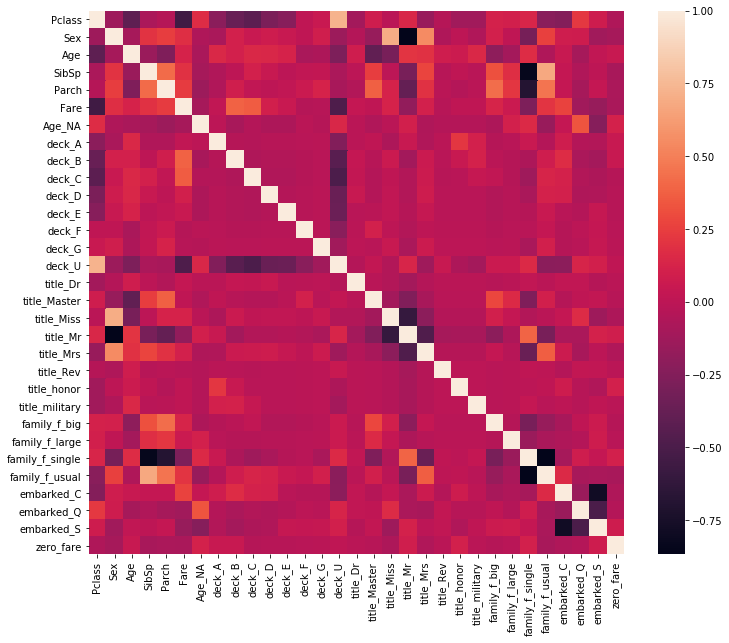

In [16]:
# Correlation - 
# Correlation refers to how close two variables are to having a linear relationship with each other. 
# Features with high correlation are more linearly dependent and hence have almost the same effect on the dependent variable.
# So, when two features have high correlation, we can drop one of the two features
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,10))
cor = all_train_features.corr()
sns.heatmap(cor)

In [26]:
# Models

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
# set model. max_iter - Maximum number of iterations taken for the solvers to converge.
lg_model = LogisticRegression(random_state = 64, max_iter = 1000)
# set parameters values we are going to check
optimization_dict = {'class_weight':['balanced', None],
                     'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                     'C': [0.01, 0.05, 0.07, 0.1, 0.5, 1, 2, 4, 5, 10, 15, 20]}

# set GridSearchCV parameters
model = GridSearchCV(lg_model, optimization_dict, scoring='accuracy', n_jobs = -1, cv = 10)

# use training features
model.fit(all_train_features, all_train_label)

# print result
print(model.best_score_)
print(model.best_params_)

0.8339200998751559
{'C': 0.5, 'class_weight': None, 'solver': 'newton-cg'}


In [28]:
# set best parameters to the model
lg_tuned_model = LogisticRegression(solver = 'newton-cg',
                                   C = 0.5,
                                   random_state = 64,
                                   n_jobs = -1)

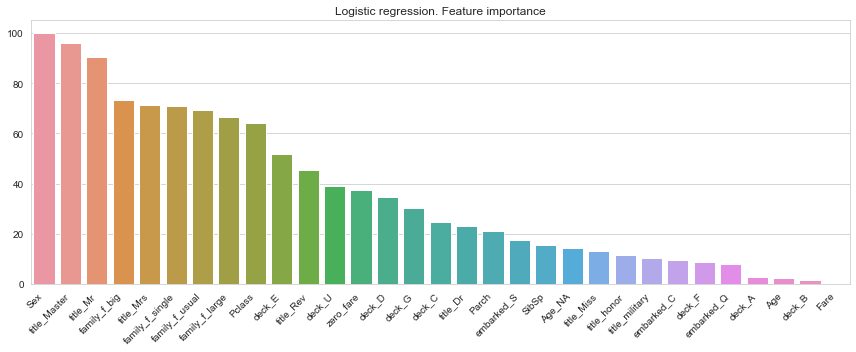

In [31]:
# feature importance
# for better understanding our data and how our model works, now we can calculate and visualize feature importance!

# train our model with training data
lg_tuned_model.fit(all_train_features, all_train_label)

# calculate importances based on coefficients
importances = abs(lg_tuned_model.coef_[0])
importances = 100.0 * (importances / importances.max())
# sort
import numpy as np
indices = np.argsort(importances)[::-1]
# Rearrange feature names so they match the sorted feature importances
names = [all_train_features.columns[i] for i in indices]

# visualice
plt.figure(figsize = (12,5))
sns.set_style("whitegrid")
chart = sns.barplot(x =names, y = importances[indices])
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light'  
)
plt.title('Logistic regression. Feature importance')
plt.tight_layout()

In [33]:
# random forest
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(oob_score = True, n_jobs = -1, random_state = 64)
# create a dictionary of parameters values we want to try
optimization_dict = {'criterion':['gini', 'entropy'],
                     'n_estimators': [100, 500, 1000, 1700],
                     'max_depth': [7, 10, 11, 12],
                     'min_samples_split': [6, 7, 8, 10],
                     'min_samples_leaf': [3, 4, 5]
                     }

# set GridSearchCV parameters
model = GridSearchCV(rf_model, optimization_dict, scoring = 'accuracy', verbose = 1, n_jobs = -1, cv = 5)

# use training data
model.fit(all_train_features, all_train_label)

# print best score and best parameters combination
print(model.best_score_)
print(model.best_params_)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 18.8min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 27.2min
[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed: 29.3min finished


0.8350072186303434
{'criterion': 'gini', 'max_depth': 12, 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 100}


In [36]:
# set best parameters to the model
rf_tuned_model = RandomForestClassifier(criterion = 'gini',
                                       n_estimators = 100,
                                       max_depth = 12,
                                       min_samples_split = 6,
                                       min_samples_leaf = 4,
                                       max_features = 'auto',
                                       oob_score = True,
                                       random_state = 64,
                                       n_jobs = -1)

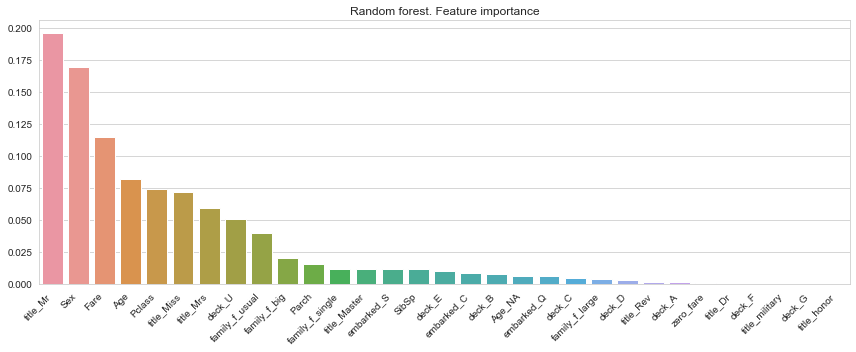

In [37]:
# feature importance

# train model using training dataset
rf_tuned_model.fit(all_train_features, all_train_label)

# Calculate feature importances
importances = rf_tuned_model.feature_importances_

# Visualize Feature Importance
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [all_train_features.columns[i] for i in indices]

plt.figure(figsize = (12, 5))
sns.set_style("whitegrid")
chart = sns.barplot(x = names, y=importances[indices])
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light'  
)
plt.title('Random forest. Feature importance')
plt.tight_layout()

In [41]:
# xgboost
from xgboost import XGBClassifier
xgb_model = XGBClassifier(random_state = 64)

# create a dictionary of parameters values we want to try
optimization_dict = {'n_estimators': [200, 1000, 1700, 2000],
                    'max_depth': [4, 6, 8, 10],
                     'learning_rate': [0.001, 0.01, 0.1, 0.5],
                     'gamma': [0, 1, 5],
                     'min_child_weight':[3, 6, 10],
                     'subsample': [0.5, 0.8, 0.9]
                    }

# set GridSearchCV parameters
model = GridSearchCV(xgb_model, optimization_dict, scoring = 'accuracy', verbose = 1, n_jobs = -1, cv = 5)

# use training data
model.fit(all_train_features, all_train_label)
print(model.best_score_)
print(model.best_params_)

In [50]:
# set model with best parameters
xgb_tuned_model =  XGBClassifier(n_estimators = 200,
                               max_depth = 8,
                               learning_rate = 0.5,
                               gamma = 1,
                               min_child_weight = 6,
                               subsample = 0.9,
                               random_state = 64)

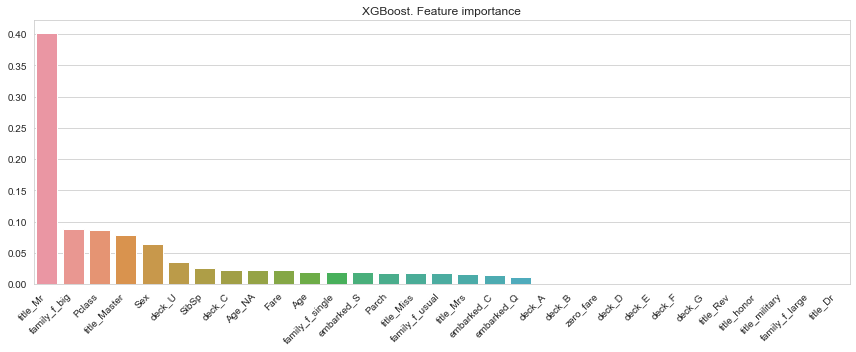

In [51]:
# train model with training dataset
xgb_tuned_model.fit(all_train_features, all_train_label)

# Calculate feature importances
importances = xgb_tuned_model.feature_importances_

# Visualize Feature Importance
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [all_train_features.columns[i] for i in indices]

plt.figure(figsize = (12, 5))
sns.set_style("whitegrid")
chart = sns.barplot(x = names, y=importances[indices])
plt.xticks(rotation=45, horizontalalignment='right', fontweight='light')
plt.title('XGBoost. Feature importance')
plt.tight_layout()

In [57]:
# compare models
# To compare models, I will use cross-validation technique as well. 
# To do it, I will use model_selection.KFold to split data on 'folders' 
# and model_selection.cross_val_score to get accuracy scores from each iterations.

models = []
models.append(('Logistic Regression', lg_tuned_model))
models.append(('Random Forest', rf_tuned_model))
models.append(('XGBoost', xgb_tuned_model))

results = []
names = []

# evaluate each model in turn
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
for name, model in models:
    kfold = KFold(n_splits = 10, shuffle = True, random_state = 64)
    cv_results = cross_val_score(model, all_train_features, all_train_label, cv = 10, scoring = 'accuracy')
    results.append(cv_results)
    names.append(name)
    
    # print mean accuracy and standard deviation
    print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))

Logistic Regression: 0.833920 (0.033858)
Random Forest: 0.830549 (0.035213)
XGBoost: 0.835031 (0.034018)


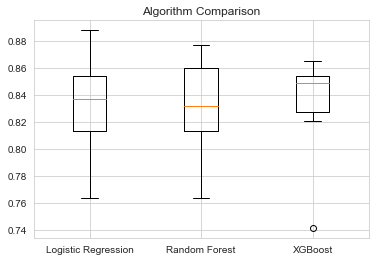

In [58]:
fig = plt.figure(figsize = (6,4))
plt.boxplot(results)
plt.title('Algorithm Comparison')
plt.xticks([1,2,3], names)
plt.show()

In [59]:
# train chosen model on training dataset
lg_tuned_model.fit(all_train_features, all_train_label)

# get predictions on test dataset
predictions = lg_tuned_model.predict(all_test_features)

# Save results in the required format
output = pd.DataFrame({'PassengerId': test_data.PassengerId,
                       'Survived': predictions})
output.to_csv('submission_lg.csv', index=False)
output.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [60]:
# train chosen model on training dataset
rf_tuned_model.fit(all_train_features, all_train_label)

# get predictions on test dataset
predictions = rf_tuned_model.predict(all_test_features)

# Save results in the required format
output = pd.DataFrame({'PassengerId': test_data.PassengerId,
                       'Survived': predictions})
output.to_csv('submission_rf.csv', index=False)
output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [61]:
# train chosen model on training dataset
xgb_tuned_model.fit(all_train_features, all_train_label)

# get predictions on test dataset
predictions = xgb_tuned_model.predict(all_test_features)

# Save results in the required format
output = pd.DataFrame({'PassengerId': test_data.PassengerId,
                       'Survived': predictions})
output.to_csv('submission_xgb.csv', index=False)
output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
